In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

In [3]:
train_df.shape, test_df.shape

((26370, 41), (6593, 40))

In [4]:
# change value 9 to nan
train_df = train_df.replace(9, np.nan)
test_df = test_df.replace(9, np.nan)

In [5]:
# train_df.drop('id', axis=1, inplace=True)
train_df['Price'] = train_df['Price'].apply(lambda x: x / 1000).astype(int)
train_df.head()

,id,Area,Location,No. of Bedrooms,Resale,MaintenanceStaff,Gymnasium,SwimmingPool,LandscapedGardens,JoggingTrack,...,BED,VaastuCompliant,Microwave,GolfCourse,TV,DiningTable,Sofa,Wardrobe,Refrigerator,Price
0,26813.0,964,Hooghly Chinsurah,3.0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7500
1,10365.0,1075,Virar West,2.0,1,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6200
2,17863.0,2092,Manikonda,3.0,0,1.0,1.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10400
3,24337.0,1174,Devanahalli,2.0,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18600
4,12590.0,1380,Kharghar,2.0,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9500


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26370 entries, 0 to 26369
Data columns (total 41 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   26369 non-null  float64
 1   Area                 26370 non-null  int64  
 2   Location             26370 non-null  object 
 3   No. of Bedrooms      26369 non-null  float64
 4   Resale               26370 non-null  int64  
 5   MaintenanceStaff     8124 non-null   float64
 6   Gymnasium            8124 non-null   float64
 7   SwimmingPool         8124 non-null   float64
 8   LandscapedGardens    8124 non-null   float64
 9   JoggingTrack         8124 non-null   float64
 10  RainWaterHarvesting  8124 non-null   float64
 11  IndoorGames          8124 non-null   float64
 12  ShoppingMall         8124 non-null   float64
 13  Intercom             8124 non-null   float64
 14  SportsFacility       8124 non-null   float64
 15  ATM                  8124 non-null  

In [7]:
missing_per_row = train_df.isnull().sum(axis=1)
missing_per_row.groupby(missing_per_row).count()

0      8123
1         1
35    18245
36        1
dtype: int64

In [8]:
columns_with_missing = train_df.columns[train_df.isnull().any()]

# Điền các giá trị bị thiếu bằng trung vị của từng nhóm dựa trên 'Location'
for column in columns_with_missing:
    train_df[column] = train_df.groupby('Location', observed=True)[column].apply(
        lambda x: x.fillna(x.median() if not x.dropna().empty else train_df[column].median())
    ).reset_index(level='Location', drop=True)
    test_df[column] = test_df.groupby('Location', observed=True)[column].apply(
        lambda x: x.fillna(x.median() if not x.dropna().empty else test_df[column].median())
    ).reset_index(level='Location', drop=True)



In [9]:
if train_df.duplicated().sum() == 0:
    print('No duplicates in train data')
else:
    print(f'Data train has {train_df.duplicated().sum()} duplicates', end=' ')
    train_df.drop_duplicates(inplace=True)
    print('and they were removed')
    
if test_df.duplicated().sum() == 0:
    print('No duplicates in test data')
else:
    print(f'Data test has {test_df.duplicated().sum()} duplicates', end=' ')
    test_df.drop_duplicates(inplace=True)
    print('and they were removed')



No duplicates in train data
No duplicates in test data


In [10]:
if train_df.duplicated(subset=['id']).sum() == 0:
    print('No duplicates id in train data')
else:
    print(f'Data train has {train_df.duplicated(subset=["id"]).sum()} duplicates in id', end=' ')
    train_df.drop_duplicates(subset=['id'], inplace=True)
    print('and they were removed')

Data train has 1 duplicates in id and they were removed


In [11]:
train_df.groupby(['Location'])['Price'].max().sort_values(ascending=False)

Location
Vasant Kunj             854599
Sunder Nagar            854599
Saket                   748100
West End                704400
Sector 4 Dwarka         654599
                         ...  
Sector-26 Taloja          2100
Asangaon                  2035
Jhangir Pet               2014
Uttar Panchanna Gram      2000
Vasind                    2000
Name: Price, Length: 1640, dtype: int32

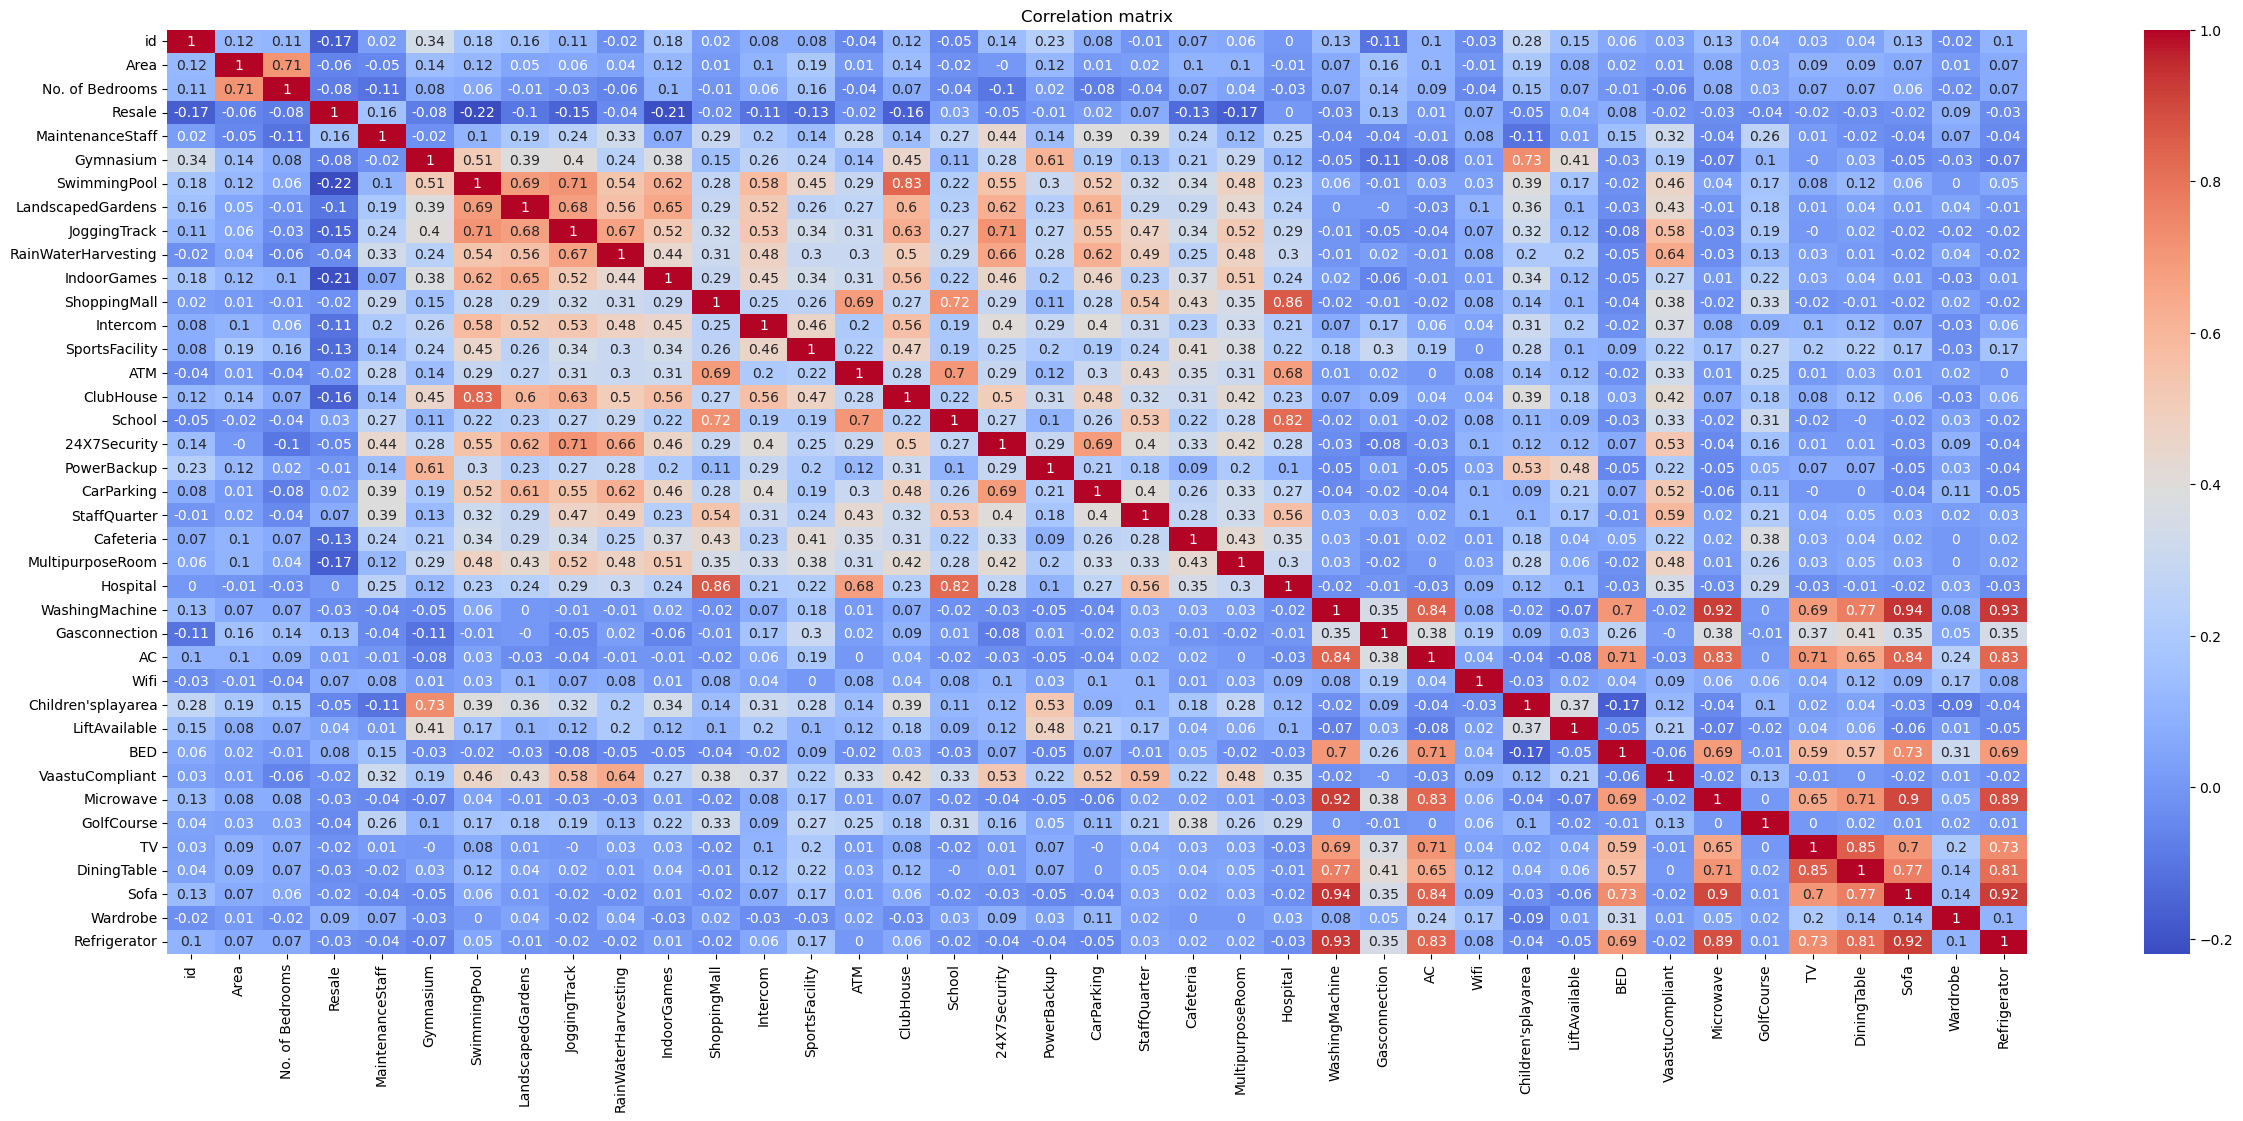

In [12]:
# correlation matrix for numerical columns
corr_matrix = train_df.select_dtypes(include=['int64', 'float64']).corr().round(2)
plt.figure(figsize=(30, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation matrix')
plt.show()

In [13]:
# drop columns with correlation 
corr_matrix = train_df.select_dtypes(include=['int64', 'float64']).corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] >= 0.8)]
train_df.drop(to_drop, axis=1, inplace=True)
test_df.drop(to_drop, axis=1, inplace=True)
print(f'Dropped columns: {to_drop}')

## Test with many models

In [14]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, LabelEncoder

label_encoder = LabelEncoder()
train_df['Location'] = label_encoder.fit_transform(train_df['Location'])
train_df.drop('id', axis=1, inplace=True)


X = train_df.drop('Price', axis=1)
y = train_df['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [15]:
# best model for regression: RandomForestRegressor, GradientBoostingRegressor, XGBRegressor, LGBMRegressor, CatBoostRegressor, 
from sklearn.ensemble import RandomForestRegressor
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(),
    'LGBM': LGBMRegressor(),
    'XGB': XGBRegressor(),
    'CatBoost': CatBoostRegressor()
}

for name, model in models.items():
    if name in ['CatBoost','LGBM']:
        model.set_params(verbose=0)
    model.fit(X_train_scaled, y_train)
    
    y_pred = model.predict(X_test_scaled)
    print(f'{name} RMSE: {root_mean_squared_error(y_test, y_pred)}')
    print(f'{name} R2 score: {r2_score(y_test, y_pred)}')



Linear Regression RMSE: 19752.828520834584
Linear Regression R2 score: 0.08778057545464868
Random Forest RMSE: 20723.707648711854
Random Forest R2 score: -0.004096938082895907
LGBM RMSE: 19376.688551660798
LGBM R2 score: 0.12219137005425951
XGB RMSE: 22165.511615934287
XGB R2 score: -0.14867256542797347
CatBoost RMSE: 20151.733729222015
CatBoost R2 score: 0.05056429322982203


In [16]:

param_rf = {
    'n_estimators': Integer(400, 700),
    'max_depth': Integer(10, 50),
    'max_features': Categorical(['sqrt', 'log2', None])
}


param_lgbm = {
    'num_leaves': Integer(30, 70),
    'learning_rate': Real(0.01, 0.1),
    'n_estimators': Integer(300, 700),
    'subsample': Real(0.1, 1.0),
    'colsample_bytree': Real(0.1, 1.0)
}

param_xgb = {
    'max_depth': Integer(3, 10),
    'learning_rate': Real(0.01, 0.3),
    'n_estimators': Integer(100, 500),
    'subsample': Real(0.6, 1.0),
    'colsample_bytree': Real(0.6, 1.0)
}

param_cat = {
    'depth': Integer(1, 7),
    'learning_rate': Real(0.01, 0.1),
    'iterations': Integer(300, 600),
    'bagging_temperature': Real(1.0, 5.0),
    'l2_leaf_reg': Real(1, 5)
}


np.int = int
opt_lgbm = BayesSearchCV(
    LGBMRegressor(),
    param_lgbm,
    n_iter=32,
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=42,
)

opt_xgb = BayesSearchCV(
    XGBRegressor(),
    param_xgb,
    n_iter=32,
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=42,
)

opt_cat = BayesSearchCV(
    CatBoostRegressor(),
    param_cat,
    n_iter=32,
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=42,
)


opt_rf = BayesSearchCV(
    RandomForestRegressor(),
    param_rf,
    n_iter=32,
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=42,
)

opt_models = {
    'LGBM': opt_lgbm,
    'XGB': opt_xgb,
    'CatBoost': opt_cat,
    'Random Forest': opt_rf
}

for name, model in opt_models.items():
    if name in ['CatBoost','LGBM']:
        model.set_params(verbose=0)
        
    model.fit(X_train_scaled, y_train)
    print(f'{name} r2: {model.best_score_}')
    for param, value in model.best_params_.items():
        print(f'{param}: {value}')
    print()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002387 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 662
[LightGBM] [Info] Number of data points in the train set: 21095, number of used features: 39
[LightGBM] [Info] Start training from score 11595.678455
LGBM r2: -21555.794857335302
colsample_bytree: 0.688097101129625
learning_rate: 0.01
n_estimators: 499
num_leaves: 70
subsample: 0.5593642477818485

XGB r2: -21379.29024967366
colsample_bytree: 1.0
learning_rate: 0.043003384521546256
max_depth: 3
n_estimators: 500
subsample: 1.0

0:	learn: 23236.1727773	total: 7.86ms	remaining: 4.71s
1:	learn: 23061.4058884	total: 10ms	remaining: 2.99s
2:	learn: 22850.9242130	total: 11.9ms	remaining: 2.38s
3:	learn: 22727.7898319	total: 14.4ms	remaining: 2.15s
4:	learn: 22632.2154588	total: 16.4ms	remaining: 1.95s
5:	learn: 22537.4523069	total: 18.1ms

c:\Users\HP\anaconda3\envs\min_ds-env\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\HP\anaconda3\envs\min_ds-env\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\HP\anaconda3\envs\min_ds-env\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\HP\anaconda3\envs\min_ds-env\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\HP\anaconda3\envs\min_ds-env\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  

Random Forest r2: -21553.93117868713
max_depth: 10
max_features: log2
n_estimators: 700



In [17]:
X_combined = pd.concat([X_train, X_test])
y_combined = pd.concat([y_train, y_test])

X_combined = scaler.fit_transform(X_combined)

opt_lgbm.best_estimator_.fit(X_combined, y_combined)
opt_xgb.best_estimator_.fit(X_combined, y_combined)
opt_cat.best_estimator_.fit(X_combined, y_combined)

rmse_test = {}
r2_test = {}
for name, model in opt_models.items():
    model.set_params(verbose=0)
    y_pred = model.best_estimator_.predict(X_test_scaled)
    rmse_test[name] = root_mean_squared_error(y_test, y_pred)
    r2_test[name] = r2_score(y_test, y_pred)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002282 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 662
[LightGBM] [Info] Number of data points in the train set: 26369, number of used features: 39
[LightGBM] [Info] Start training from score 11627.666313
0:	learn: 22797.1168362	total: 4.21ms	remaining: 2.52s
1:	learn: 22634.7948954	total: 7.22ms	remaining: 2.16s
2:	learn: 22512.4195450	total: 10.6ms	remaining: 2.1s
3:	learn: 22403.5392213	total: 12.6ms	remaining: 1.88s
4:	learn: 22312.1828028	total: 15.2ms	remaining: 1.8s
5:	learn: 22236.1013403	total: 18.2ms	remaining: 1.8s
6:	learn: 22131.6034740	total: 20.4ms	remaining: 1.73s
7:	learn: 22079.7433478	total: 23.6ms	remaining: 1.74s
8:	learn: 22035.3031349	total: 25.9ms	remaining: 1.7s
9:	learn: 21980.8420924	total: 28.4ms	remaining: 1.68s
10:	learn: 21861.2043175	total: 31.1ms	remain

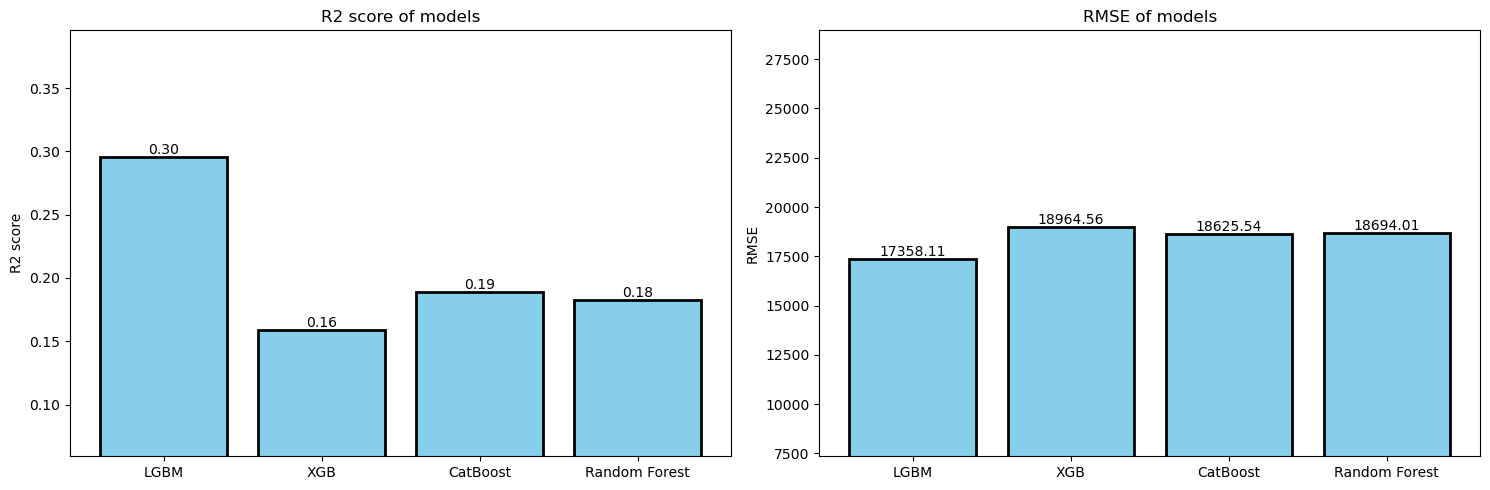

In [18]:
categories = list(r2_test.keys())
r2_values = list(r2_test.values())
rmse_test_values = list(rmse_test.values())

indices = np.arange(len(categories))

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

bars1 = ax[0].bar(indices, r2_values, color='skyblue', edgecolor='black', linewidth=2)
ax[0].set_ylabel('R2 score')
ax[0].set_xticks(indices)
ax[0].set_xticklabels(categories)
ax[0].set_title('R2 score of models')
ax[0].set_ylim(min(r2_values) - 0.1, max(r2_values) + 0.1)
ax[0].bar_label(bars1, fmt='%.2f')

bars2 = ax[1].bar(indices, rmse_test_values, color='skyblue', edgecolor='black', linewidth=2)
ax[1].set_ylabel('RMSE')
ax[1].set_xticks(indices)
ax[1].set_xticklabels(categories)
ax[1].set_title('RMSE of models')
ax[1].set_ylim(min(rmse_test_values) - 10000, max(rmse_test_values) + 10000)
ax[1].bar_label(bars2, fmt='%.2f')

plt.tight_layout()
plt.show()

In [19]:
best_model = min(rmse_test, key=rmse_test.get)

real_test_df = test_df.copy()
unseen_labels = set(real_test_df['Location']) - set(label_encoder.classes_)
if unseen_labels:
    label_encoder.classes_ = np.append(label_encoder.classes_, list(unseen_labels))
real_test_df['Location'] = label_encoder.transform(real_test_df['Location'])

X_real_test = real_test_df.drop('id', axis=1)
X_real_test_scaled = scaler.transform(X_real_test)
y_real_test = opt_models[best_model].best_estimator_.predict(X_real_test_scaled)
y_real_test = y_real_test * 1000


submission = pd.DataFrame({'id': test_df['id'], 'Price': y_real_test})
submission.to_csv('submission.csv', index=False)